In [302]:
import psycopg2
import matplotlib
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import re

In [303]:
pd.set_option('display.max_rows', 200)

In [304]:
connection = psycopg2.connect(
    user = "postgres", 
    password = "docker", 
    host = "localhost", 
    port = "5432", 
    database = "postgres"
)
cursor = connection.cursor()

In [305]:
resp = cursor.execute("SELECT count(*) FROM performance;")
record = cursor.fetchone()
assert record[0] > 0

In [309]:
cursor.execute("""
    SELECT 
        perf.*,
        news.title,
        news.content,
        news.time
    FROM performance perf
    JOIN news 
        ON news.url = perf.url
    WHERE perf.performance IS NOT NULL
;""")
records = cursor.fetchall()
columns = [desc[0] for desc in cursor.description]
perf_df = pd.DataFrame(records, columns=columns)
print(perf_df.size)
perf_df.sample(3)

73440


,url,strategy,symbol,performance,extractor,title,content,time
3491,https://binance.zendesk.com/hc/en-us/articles/...,follower2,USDCUSDT,-0.079531,relatedAgainstUsdt,Binance Will Add Additional Trading Pairs for GTO,"Fellow Binancians,\nBinance will open trading ...",2019-07-01 02:59:30+00:00
791,https://binance.zendesk.com/hc/en-us/articles/...,follower0_5,BNBUSDT,1.388728,relatedAgainstUsdt,Binance Lists SingularityNET (AGI),"Fellow Binancians,\nBinance will open trading ...",2018-06-05 07:14:36+00:00
7558,https://binance.zendesk.com/hc/en-us/articles/...,follower2,BNBUSDT,1.435618,onlyBnb,"Binance Loans Adds BCH, LTC and XRP as Collate...","Fellow Binancians,\nBinance has added BCH, LTC...",2020-04-14 11:03:08+00:00


In [310]:
meaningless_words = ['to', 'and', 'will', 'of', 'the', 'for', 'on', '', 'by', 'a', 'an', 'as', 'in', 'be', 'has', 'have']
def format_title(title):
    clean_title = re.sub('[^A-Za-z0-9 ]+', ' ', title.lower())
    without_duplicate_space_title = re.sub(' +', ' ',clean_title)
    words = clean_title.split(' ')
    uniq_words = list(set(words))
    meaningful_words = [word for word in uniq_words if word not in meaningless_words]
    return meaningful_words

In [311]:
word_df = perf_df.copy()
word_df['words'] = word_df['title'].apply(format_title)

In [323]:
words_exploded_df = word_df \
    .explode('words') \
    .groupby(['words', 'extractor', 'strategy', 'symbol']) \
    .agg(
        count=('words', 'count'), 
        computed_perf=('performance', 'mean')
    ).sort_values(['computed_perf'], ascending=False)

In [325]:
words_exploded_df.head(20)

,,,,count,computed_perf
words,extractor,strategy,symbol,,
trading,relatedAgainstUsdt,highestStrategy,DATAUSDT,1,43.117179
data,relatedAgainstUsdt,highestStrategy,DATAUSDT,1,43.117179
won,relatedAgainstUsdt,highestStrategy,DATAUSDT,1,43.117179
3,relatedAgainstUsdt,highestStrategy,DATAUSDT,1,43.117179
competition,relatedAgainstUsdt,highestStrategy,DATAUSDT,1,43.117179
000,relatedAgainstUsdt,highestStrategy,DATAUSDT,1,43.117179
new,relatedAgainstBnb,highestStrategy,STEEMBNB,1,39.217557
holders,relatedAgainstBnb,highestStrategy,STEEMBNB,1,39.217557
hard,relatedAgainstBnb,highestStrategy,STEEMBNB,1,39.217557


In [327]:
array = words_exploded_df.reset_index()
strategyFilter = array['strategy'] != 'highestStrategy'
extractorFilter =  array['extractor'] == 'relatedAgainstUsdt'
filtered_array = array[
    strategyFilter & 
    extractorFilter &
    countFilter
].sort_values(['computed_perf'], ascending=False)
filtered_array.head(100)

,words,extractor,strategy,symbol,count,computed_perf
4118,adds,relatedAgainstUsdt,follower2,BNBUSDT,9,2.218283
4155,adds,relatedAgainstUsdt,follower1,BNBUSDT,9,2.194910
4226,adds,relatedAgainstUsdt,follower10,BNBUSDT,9,2.155283
4227,adds,relatedAgainstUsdt,follower5,BNBUSDT,9,2.155283
5612,xtz,relatedAgainstUsdt,follower2,XTZUSDT,6,1.555840
6010,bnb,relatedAgainstUsdt,follower2,BNBUSDT,14,1.461188
6129,bnb,relatedAgainstUsdt,follower10,BNBUSDT,14,1.420688
6130,bnb,relatedAgainstUsdt,follower5,BNBUSDT,14,1.420688
6149,bnb,relatedAgainstUsdt,follower1,BNBUSDT,14,1.414472
6405,xtz,relatedAgainstUsdt,follower5,XTZUSDT,6,1.371773


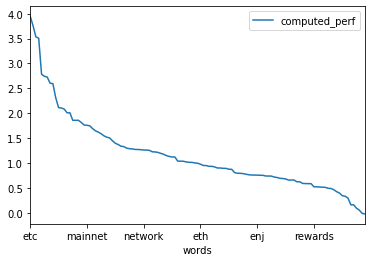

In [316]:
filtered_array.plot(x='words', y='computed_perf')